## Is our $CO_2$ reading correct?

I am beginning to suspect our $CO_2$ reading. Given your last run with HPLC measurements I am going to fit the growth curve and use this when obtaining $r_{CO_2}$ via the model.

Let's start with your growth data. I will be using Suvira's short run (ferm 4):


In [66]:
te=[0,1,2,3,4,5,6,7]
Cx_e=[1.670877123,1.921508001,2.31054237,3.237087469,4.104799739,5.629561616,6.701583683,8.074238701]
rco2_e=[2.31884058,3.571428571,5.504587156,7.817589577,11.00917431,12.8342246,13.04347826,6.16966581]

Please note that I have started my time zero after 2 hours of experimentation. Let's first see how a constant $\mu$ value fits the data:

In [48]:
import numpy
import matplotlib.pyplot as plt
from scipy.integrate import odeint
%matplotlib inline

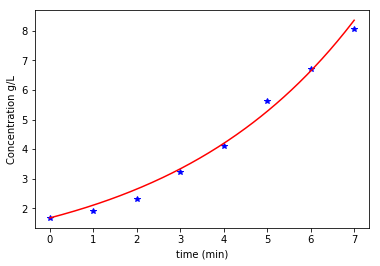

In [57]:
tspan=numpy.linspace(0,7,200)
mu=0.23

def intfun(c,t):
    return [(mu)*c[0]]                     

Cx_t = odeint(intfun, Cx[0], tspan)  

plt.plot(te, Cx_e, '*',color='blue', label='cx')
plt.plot(tspan, Cx_t, color='red', label='cx_t')
plt.ylabel('Concentration g/L') 
plt.xlabel('time (min)') 
plt.show()

Not perfect but good enough for now. No clear evidence of product inhibition so we'll start by using $\mu=0.23 \frac{1}{h}$

So we will run the model with a constant $\mu$ and vary the energy balance parameters to obtain a fit on the glucose and ethanol data. Let's start with the model:

<img src="etmap.png" width="600" />

Unlike the basis in this model we will use $\mu$ as the basis. Let's generate some concentration profiles:

In [58]:
alpha, beta, gamma = 0.1, 0.1,1.2
mu, theta, Km= 0.23, 0.1, 0.001

In [59]:
def response_fun(C):
    
    Cx, Cs, Cg, Ce = C[0],C[1],C[2],C[3] 
    
    mu1=mu*Cs/(Km+Cs)
    theta1=theta*Cs/(Km+Cs)
             
    S = numpy.matrix([[-1,1+alpha,1,0,0],
                      [ 0,0,-1,1,1.5],
                      [  0,beta,0,-1/3,0],
                      [ 0,-gamma,-1/3,0,1],
                      [ 0,1,0,0,0]])

    C = numpy.matrix([0, 0, 0, theta1, mu1]).T
    r = numpy.linalg.solve(S, C) 
        
    
    return [mu,        # important to see the order of the rates (X,S,G,E)
           -r[0,0],   # glucose, note the negative since the flux model calculated (-rs)
            r[3,0],    # glycerol
            r[4,0]]    # ethanol   

In [60]:
def ferm_eq(C,t):
    Cx, Cs, Cg, Ce = C[0],C[1],C[2],C[3]   
    r=response_fun([Cx, Cs, Cg, Ce])
    
    return [r[0]*Cx,
            r[1]*Cx,    
            r[2]*Cx,
            r[3]*Cx]   

Let's import the experimental concentration data:


In [61]:
te2=[0,2,4,6]
Ce_e=[9.69552,11.86366,19.77011,28.65115]
Cs_e=[53.53423,48.20409,33.73149,12.78452]

Solve the model and plot:


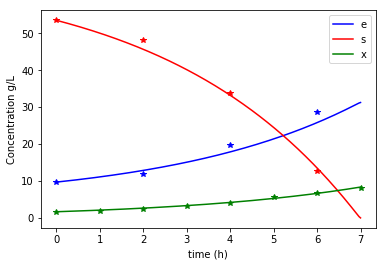

In [64]:
Co=[Cx[0]/24.6, Cs_e[0]/30,0,Ce_e[0]/23]
tmax=7
tspan=numpy.linspace(0,tmax,200)            
C = odeint(ferm_eq, Co, tspan)

Cx=C[:,0]*24.6                          
Cs=C[:,1]*30
Cg=C[:,2]*30.666
Ce=C[:,3]*23

plt.plot(tspan, Ce, color='blue', label='e')
plt.plot(tspan, Cs, color='red',label='s')
plt.plot(tspan, Cx, color='green',label='x')
plt.plot(te2, Cs_e,'*', color='red')
plt.plot(te2, Ce_e,'*', color='blue')
plt.plot(te, Cx_e, '*', color='green')

plt.legend(loc='best')
plt.ylabel('Concentration g/L') 
plt.xlabel('time (h)') 
plt.show()

Interesting, given the previously measured $\theta=0.1 \frac{mol \, ATP}{cmol \, X \cdot h}$ it appears that $\gamma$ is lower than the usual $1.8 \frac{mol \, ATP}{cmol \, X}$. This is most likely attributed to the yeast extract supplying peptides. Remember peptides take ATP to build.

Now let's see how good the $r_{CO2}$ measurement was:

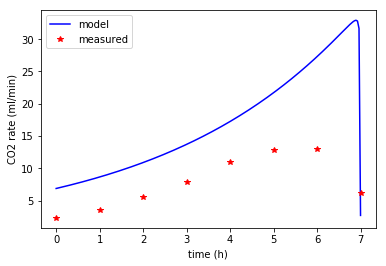

In [72]:
from numpy import asarray
Ci=(C[:, :3])                                  #first 4 elements of N devided by 5th element to get Ci, 
r=asarray([response_fun(C) for C in C])        # All Ci rows assigned (one by one) to function r_prime

T, P = 25, 86  # °C, kPa 

rx=r[:,0]
re=r[:,3]
rco2=(0.5*re+beta*rx)*(1/60)*8.314*(T+273)*1000/P*(Cx/24.6)*0.5  #ml CO2/min   

plt.plot(tspan, rco2, color='blue', label='model')
plt.plot(te, rco2_e, '*', color='red',label='measured')

plt.legend(loc='best')
plt.ylabel('CO2 rate (ml/min)') 
plt.xlabel('time (h)') 
plt.show()

Wow, it appears that the $CO_2$ absorption in the pipette is severe. Time for some vegatable oil, or low pH water or another plan I guess. We need a liquid that does not absorb $CO_2$ and that is not too messy to work with.

Also, the model suggest that you might be consuming all your glucose. Is this the reason for that 'turn'?

I guess you can take it from here. It is a fun project! 🧐